# Neural networks

Intro

## Plan

1. Image classifier demo using `fastai`
2. Implementing a network from scratch
3. Plans for future talks

In [1]:
%matplotlib inline

import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import torch

## Quick `fastai` demo

Building AI models doesn't have to be hard

In [2]:
from fastai.vision.utils import download_images, resize_images
from duckduckgo_search import ddg_images
from pathlib import Path
import shutil

def download_images_of(query, dest, max_results=10):
    results = ddg_images(query, max_results=max_results)
    urls = [result["image"] for result in results]
    
    tmp_path = Path(dest) / "tmp"
    tmp_path.mkdir(parents=True, exist_ok=True)
    download_images(tmp_path, urls=urls)
    resize_images(tmp_path, dest=dest, max_size=400, ext=".jpg", img_format="jpeg")
    shutil.rmtree(tmp_path)

Let's try to create a husky vs wolf classifier. 

First we need some photos of wolves and huskies, no problem, we can pull them from [duckduckgo](https://duckduckgo.com/?q=gray+wolf&t=h_&iax=images&ia=images).

In [3]:
demo_path = Path("..") / "data" / "dog_vs_wolf_demo"

In [4]:
# shutil.rmtree(demo_path, ignore_errors=True)

In [5]:
if not demo_path.exists():
    samples_per_class = 200
    download_images_of("gray wolf", dest=demo_path / "gray_wolf", max_results=samples_per_class)
    download_images_of("white wolf", dest=demo_path / "arctic_wolf", max_results=int(samples_per_class / 2))
    download_images_of("arctic wolf", dest=demo_path / "arctic_wolf", max_results=int(samples_per_class / 2))
    download_images_of("malamute", dest=demo_path / "malamute_husky", max_results=samples_per_class)
    download_images_of("siberian husky", dest=demo_path / "siberian_husky", max_results=samples_per_class)

Next we need to tell `fastai` where the photos are, how they are labeled and how the data should be split into training and validation sets.

In [6]:
from fastai.vision.data import ImageDataLoaders
from fastai.vision.augment import Resize, aug_transforms

demo_dls = ImageDataLoaders.from_path_func(
    demo_path,
    list(demo_path.glob("**/*.jpg")),
    label_func=lambda path: Path(path).parent.name,
    valid_pct=0.2,
    seed=1432,
    item_tfms=[Resize(224)],
    batch_tfms=aug_transforms(),
)

...and here's how our photos look like

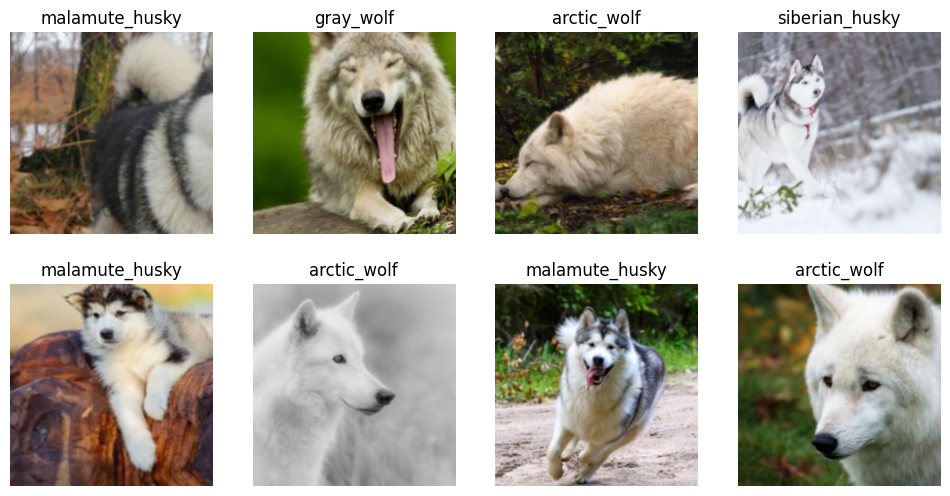

In [7]:
demo_dls.show_batch(max_n=8)

Now we can train our first model

In [8]:
import fastai.vision.all
from fastai.vision.learner import vision_learner
from fastai.vision.models import resnet34
from fastai.metrics import error_rate

demo_learner = vision_learner(demo_dls, resnet34, metrics=error_rate)
demo_learner.fine_tune(4, 0.0015)
torch.cuda.empty_cache()

/home/dev/workspace/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dev/workspace/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.885428,0.415671,0.167832,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.636426,0.354710,0.139860,00:03
1,0.526236,0.280747,0.097902,00:03
2,0.432849,0.244557,0.090909,00:03
3,0.378805,0.236793,0.083916,00:03


Seems to be doing pretty well for a couple seconds of training.

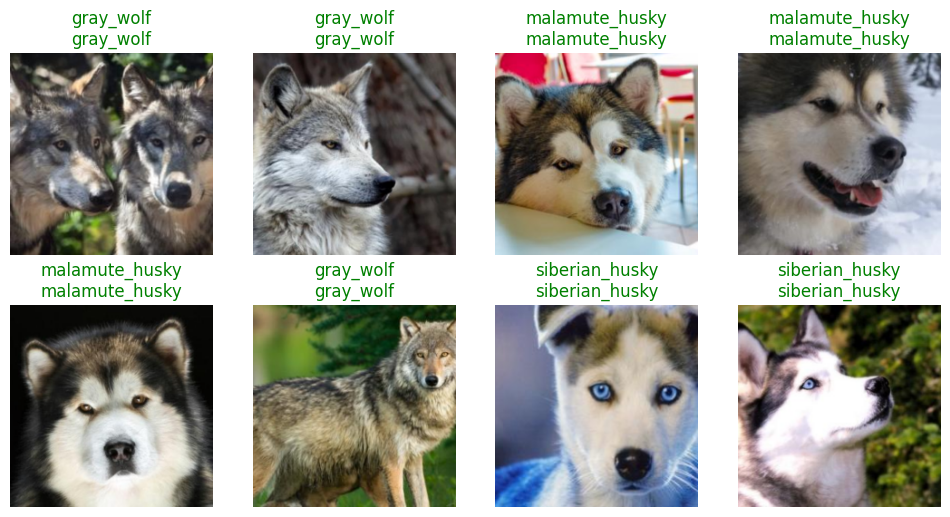

In [9]:
demo_learner.show_results(max_n=8)

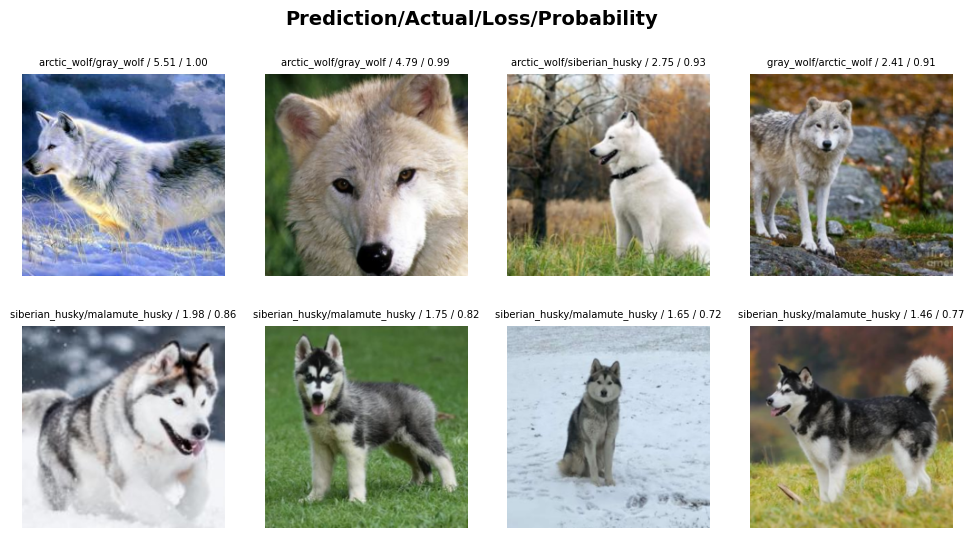

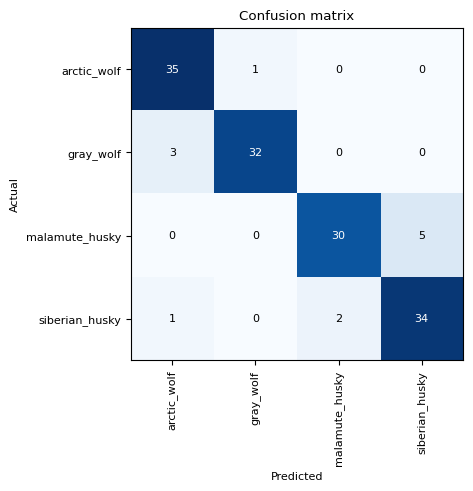

In [10]:
from fastai.interpret import Interpretation, ClassificationInterpretation

plt.rcParams.update({'font.size': 6})
Interpretation.from_learner(demo_learner).plot_top_losses(k=8)
plt.rcParams.update({'font.size': 8})

ClassificationInterpretation.from_learner(demo_learner).plot_confusion_matrix()

If we have an image we can run it through our model like so...

In [11]:
def demo_classify(image):
    category, _, probabilities = demo_learner.predict(image)
    category_probabilities = dict(zip(demo_dls.vocab, probabilities.tolist()))
    return category, category_probabilities

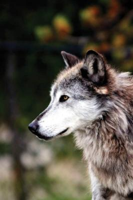

('gray_wolf',
 {'arctic_wolf': 0.008912292309105396,
  'gray_wolf': 0.9878155589103699,
  'malamute_husky': 0.00312839075922966,
  'siberian_husky': 0.00014367613766808063})

In [13]:
from fastai.vision.all import PILImage

test_image = PILImage.create(next(demo_path.glob("**/*.jpg")))
display(test_image.to_thumb(200))
demo_classify(test_image)

So let's test the model on some images

In [14]:
from fastai.vision.core import PILImage
import io

def image_widget(image):
    out = widgets.Output()
    
    with out:
        display(image)
        
    return out

# widgets.FloatProgress doesn't work with RISE, so here's a quick HTML progress bar
def progress_widget(value):
    return widgets.HTML(f"""
      <div style="
          position: relative; 
          width: 200px; 
          height: 20px; 
          background: #eee; 
          border-radius: 3px; 
          overflow: hidden;
          margin: 0 5px;
      ">
        <div style="
            position: absolute; 
            width: {value * 100}%; 
            height: 100%; 
            background: #348ceb"
        ></div>
      </div>
    """)

def probabilities_widget(probabilities):
    cells = [
        widget
        for category, probability in probabilities.items()
        for widget in (
            widgets.Label(category),
            progress_widget(probability),
            widgets.Label("{0:.2%}".format(probability)),
        )
    ]
    
    return widgets.GridBox(cells, layout=widgets.Layout(grid_template_columns="repeat(3, 1fr)"))

def interactive_demo_classify():
    def render(uploaded_files):
        if not uploaded_files:
            return
        
        uploaded_bytes = io.BytesIO(uploaded_files[0]["content"])
        uploaded_image = PILImage.create(uploaded_bytes)
        category, probabilities = demo_classify(uploaded_image)
        
        display(widgets.HBox([
            image_widget(uploaded_image.to_thumb(400)),
            widgets.VBox([
                widgets.HTML(f"<strong>{category}</strong>"),
                probabilities_widget(probabilities),
            ])
        ]))

    
    upload_widget = widgets.FileUpload(
        accept='image/jpeg', 
        multiple=False, 
        description="Upload a photo"
    )
    
    display(upload_widget)
    display(widgets.interactive_output(render, dict(uploaded_files=upload_widget)))

In [15]:
interactive_demo_classify()

FileUpload(value=(), accept='image/jpeg', description='Upload a photo')

Output()

In a future talk I'll talk about what happened here, but for now we need to get to know the basics.

## Fitting a simple function

Math incoming...

For a simple example of how neural networks work, let's try to guess parameters of a quadratic function. 

If you don't remember from school, a quadratic looks like this:

In [16]:
def quad(a, b, c):
    return lambda x: a * x**2 + b * x + c

In [17]:
def interactive_quad_sliders():
    slider_args = dict(
        min=-2, 
        max=2, 
        step=0.05, 
        continuous_update=False
    )
    
    a = widgets.FloatSlider(description="a", value=1, **slider_args)
    b = widgets.FloatSlider(description="b", value=1, **slider_args)
    c = widgets.FloatSlider(description="c", value=1, **slider_args)
    return a, b, c

In [18]:
def interactive_quad():
    def render(a, b, c):
        x = torch.linspace(-2, 2, 200)
        _, ax = plt.subplots(figsize=(4,3))
        ax.plot(x, quad(a,b,c)(x))
        ax.grid(True)
        plt.show()
    
    a, b, c = interactive_quad_sliders()
    
    display(
        widgets.HBox([a, b, c]),
        widgets.interactive_output(render, dict(a=a, b=b, c=c))
    )

In [19]:
interactive_quad()

Output()

Let's generate a random quadratic function.

In [20]:
target_params = (torch.rand(3) * 4 - 2).tolist()
target = quad(*target_params)
print("(a, b, c) =", target_params)

(a, b, c) = [1.4482731819152832, 0.9543564319610596, -1.4699475765228271]


In [21]:
def plot_target():
    x = torch.linspace(-2, 2, 200)
    _, ax = plt.subplots(figsize=(4,3))
    ax.plot(x, target(x))
    ax.grid(True)
    plt.show()

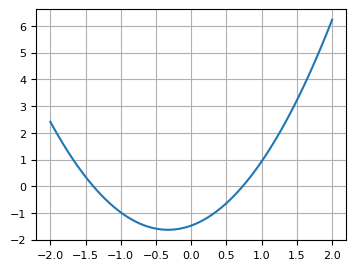

In [22]:
plot_target()

...and sample some points from it with noise, so the data isn't perfect.

In [23]:
x, _ = torch.sort(torch.rand(200) * 4 - 2)
x = x.reshape(200, 1)
y = target(x) + torch.randn_like(x) * 0.05

x.shape, y.shape

(torch.Size([200, 1]), torch.Size([200, 1]))

In [24]:
def plot_samples():
    target_x = torch.linspace(-2, 2, 200)
    target_y = target(target_x)
    
    _, ax = plt.subplots(figsize=(4,3))
    ax.scatter(x, y, s=3, c="C0", label="samples")
    ax.plot(target_x, target_y, c="C1", label="target")
    ax.grid(True)
    ax.legend()
    
    plt.show()

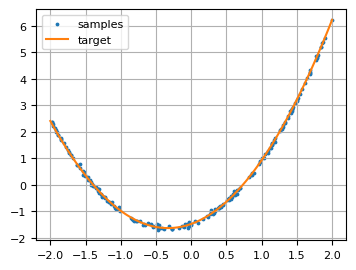

In [25]:
plot_samples()

Guessing the parameters visually

In [26]:
def fit_visually():
    def render(a, b, c):
        _, ax = plt.subplots(figsize=(4,3))
        ax.grid(True)
        ax.scatter(x, y, s=3, c="C0", label="samples")
        ax.plot(x, quad(a,b,c)(x), c="C1", label="guess")
        ax.legend()
        plt.show()
    
    a, b, c = interactive_quad_sliders()
    
    display(
        widgets.HBox([a, b, c]),
        widgets.interactive_output(render, dict(a=a, b=b, c=c))
    )

In [27]:
fit_visually()

Output()

How can we automate this process?

First off, we need to define how far away we are from the target. 

We need a function, which will take the samples and our predictions and give us a score. This is called a **loss function**.

Let's use mean squared error:

In [28]:
def mean_squared_error(target, prediction):
    return ((target - prediction) ** 2).mean(axis=0)

In [29]:
def fit_with_loss():
    def render(a, b, c):
        predict = quad(a, b, c)
        y_predicted = predict(x)

        loss = mean_squared_error(y, y_predicted)
        print("loss =", loss.item())

        _, ax = plt.subplots(figsize=(4,3))
        ax.scatter(x, y, s=3, c="C0", label="samples")
        ax.plot(x, y_predicted, c="C1", label="guess")
        ax.grid(True)
        ax.legend()
        plt.show()
    
    a, b, c = interactive_quad_sliders()
    
    display(
        widgets.HBox([a, b, c]),
        widgets.interactive_output(render, dict(a=a, b=b, c=c))
    )

In [30]:
fit_with_loss()

Output()

Now that we know how far we are, we need to figure out how to change the parameters to decrease the loss.

Let's have a look at how our loss looks like.

In [31]:
def loss_line(predict):
    a = torch.linspace(-2, 2, 50)
    y_predicted = predict(a)(x)
    
    return a, mean_squared_error(y, y_predicted)
    
def fit_with_loss_plots():
    def render(a, b, c):
        y_predicted = quad(a,b,c)(x)
        loss = mean_squared_error(y, y_predicted)

        print("loss =", loss.item())

        _, (a_ax, b_ax, c_ax) = plt.subplots(1, 3, figsize=(12,2), sharey=True)

        a_loss_line = loss_line(lambda a: quad(a, b, c))
        a_ax.plot(*a_loss_line, c="C0")
        a_ax.scatter(a, loss, c="C1")
        a_ax.set_xlabel("a")
        a_ax.set_ylabel("loss")
        a_ax.set_ylim([0, None])
        a_ax.grid(True)

        b_loss_line = loss_line(lambda b: quad(a, b, c))
        b_ax.plot(*b_loss_line, c="C0")
        b_ax.scatter(b, loss, c="C1")
        b_ax.set_xlabel("b")
        b_ax.grid(True)

        c_loss_line = loss_line(lambda c: quad(a, b, c))
        c_ax.plot(*c_loss_line, c="C0")
        c_ax.scatter(c, loss, c="C1")
        c_ax.set_xlabel("c")
        c_ax.grid(True)

        _, fit_ax = plt.subplots(figsize=(3,2))
        fit_ax.scatter(x, y, s=3, c="C0", label="samples")
        fit_ax.plot(x, y_predicted, c="C1", label="guess")
        fit_ax.set_xlabel("x")
        fit_ax.set_ylabel("y")
        fit_ax.grid(True)
        fit_ax.legend()

        plt.show()
        
    a, b, c = interactive_quad_sliders()
    
    display(
        widgets.HBox([a, b, c]),
        widgets.interactive_output(render, dict(a=a, b=b, c=c))
    )

In [32]:
fit_with_loss_plots()

Output()

We can calculate the slope of the loss function and move the parameters in the direction of decreasing loss.

The slope at a given point is called a **gradient** and so we have re-invented **gradient descent**.

In [33]:
def loss_with_gradient(a, b, c):
    params = torch.tensor([a, b, c], requires_grad=True)
    y_predicted = quad(*params)(x)
    
    loss = mean_squared_error(y, y_predicted)
    loss.backward()
    
    return (
        y_predicted.detach(), 
        loss.detach(), 
        params.grad.detach()
    )

def fit_with_gradient():
    def render(a, b, c):
        y_predicted, loss, grad = loss_with_gradient(a, b, c)
        lr = (loss / grad ** 2).min()
        
        print("loss     =", loss.item())
        print("gradient =", grad.tolist())

        _, (a_ax, b_ax, c_ax) = plt.subplots(1, 3, figsize=(12,2), sharey=True)

        a_ax.axline([a, loss.item()], [a+1, (loss+grad[0]).item()], c="C0")
        a_ax.quiver(a, loss, -lr * grad[0], 0, color="C1", angles='xy', scale_units='xy', scale=1)
        a_ax.scatter(a, loss, c="C1")
        a_ax.set_xlabel("a")
        a_ax.set_ylabel("loss")
        a_ax.set_xlim([-2, 2])
        a_ax.set_ylim([0, None])
        a_ax.grid(True)

        b_ax.axline([b, loss.item()], [b+1, (loss+grad[1]).item()], c="C0")
        b_ax.quiver(b, loss, -lr * grad[1], 0, color="C1", angles='xy', scale_units='xy', scale=1)
        b_ax.scatter(b, loss, c="C1")
        b_ax.set_xlabel("b")
        b_ax.set_xlim([-2, 2])
        b_ax.grid(True)

        c_ax.axline([c, loss.item()], [c+1, (loss+grad[2]).item()], c="C0")
        c_ax.quiver(c, loss, -lr * grad[2], 0, color="C1", angles='xy', scale_units='xy', scale=1)
        c_ax.scatter(c, loss, c="C1")
        c_ax.set_xlabel("c")
        c_ax.set_xlim([-2, 2])
        c_ax.grid(True)

        _, fit_ax = plt.subplots(figsize=(3,2))
        fit_ax.scatter(x, y, s=3, c="C0", label="samples")
        fit_ax.plot(x, y_predicted, c="C1", label="guess")
        fit_ax.set_xlabel("x")
        fit_ax.set_ylabel("y")
        fit_ax.grid(True)
        fit_ax.legend()

        plt.show()

    a, b, c = interactive_quad_sliders()
    
    display(
        widgets.HBox([a, b, c]),
        widgets.interactive_output(render, dict(a=a, b=b, c=c))
    )

In [34]:
fit_with_gradient()

Output()

We can now write the code which will do SGD for us and find our function parameters.

In [35]:
def fit_sgd(model, init_params, epochs, learning_rate):
    # prepare params for calculating loss gradient
    params = [param.clone().requires_grad_(True) for param in init_params]
    
    loss_history = []
    for _ in range(epochs):
        # evaluate our model
        y_predicted = model(*params)(x)

        # calculate the loss and the loss gradient
        loss = mean_squared_error(y, y_predicted)
        loss.backward()

        # move towards decreasing loss
        with torch.no_grad():
            for param in params:
                param.add_(-param.grad * learning_rate)
                param.grad.zero_()
            
        loss_history.append(loss.item())
    
    # calculate final loss
    y_predicted = model(*params)(x)
    loss = mean_squared_error(y, y_predicted)
    loss_history.append(loss.item())
    
    params = [param.detach() for param in params]
    return params, loss.item(), loss_history

In [36]:
def interactive_fit_quad_sgd():
    init_params = torch.rand(3) * 4 - 2
    
    def render(epochs, learning_rate):
        params, loss, loss_history = fit_sgd(quad, init_params, epochs, learning_rate)
        
        _, (loss_ax, fit_ax) = plt.subplots(1, 2, figsize=(8,3))
        
        loss_ax.plot(loss_history)
        loss_ax.set_xlabel("iteration")
        loss_ax.set_ylabel("loss")
        loss_ax.grid(True)
        
        fit_ax.scatter(x, y, s=3, c="C0", label="samples")
        fit_ax.plot(x, quad(*params)(x), c="C1", label="prediction")
        fit_ax.set_xlabel("x")
        fit_ax.set_ylabel("y")
        fit_ax.grid(True)
        fit_ax.legend()
        
        plt.show()
        
        print("params =", [param.item() for param in params])
        print("target =", list(target_params))
        print("loss   =", loss)
        
    epochs = widgets.IntSlider(
        description="epochs", 
        value=15, 
        min=1, 
        max=50, 
        step=1, 
        continuous_update=False
    )
    learning_rate = widgets.FloatLogSlider(
        description="learning rate", 
        base=10,
        value=0.1, 
        min=-3, 
        max=0, 
        step=0.05,
        continuous_update=False,
    )
    
    display(
        widgets.HBox([epochs, learning_rate]),
        widgets.interactive_output(render, dict(epochs=epochs, learning_rate=learning_rate))
    )

...and if we run our SGD implementation it approximates the parameters pretty well.

In [37]:
interactive_fit_quad_sgd()

Output()

OK... but what if I don't know what the target function is?

How do I know what parameters there are and how they are used?

We can approximate any function with a bunch of linear segments.

In [38]:
def interactive_linear_approximation():
    def render(segment_count):
        segment_i = [*range(0, len(x) - 1, round((len(x) - 1) / segment_count)), len(x) - 1]
        
        _, ax = plt.subplots(figsize=(4,3))
        
        ax.scatter(x, y, s=3, c="C0", label="samples")
        ax.plot(x[segment_i], y[segment_i], c="C1", label="approximation")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.grid(True)
        ax.legend()
        
        plt.show()
        
    segment_count = widgets.IntSlider(
        description="segments", 
        value=3, 
        min=1, 
        max=30, 
        step=1, 
        continuous_update=False
    )
    
    display(
        segment_count,
        widgets.interactive_output(render, dict(segment_count=segment_count))
    )

In [39]:
interactive_linear_approximation()

IntSlider(value=3, continuous_update=False, description='segments', max=30, min=1)

Output()

...so what we should be able to do is generate a bunch of random linear functions and somehow combine them into a non-linear result.

To introduce non-linear behavior we can use a Rectified Linear Unit (ReLU), which is just

In [40]:
def relu(x):
    return torch.max(x, torch.tensor(0))

In [41]:
def plot_relu():
    x = torch.tensor([-1, 0, 1]).reshape(3, 1)
    y = relu(x)
    
    _, ax = plt.subplots(figsize=(4,3))
    ax.plot(x, y)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.grid(True)
    plt.show()

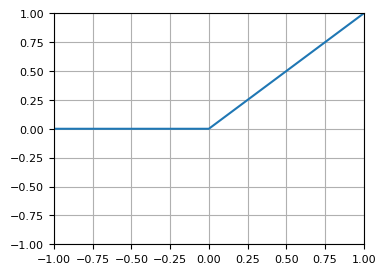

In [42]:
plot_relu()

We can pass our linear functions through ReLU and sum them up. 

A weighted sum will give us more flexibility when combining our linear segments.

In [43]:
def interactive_relu_weighted_sum():
    def render(a1, b1, a2, b2, w1, w2, c):
        x = torch.linspace(-2, 2, 200)
        y1 = relu(a1 * x + b1)
        y2 = relu(a2 * x + b2)
        y = w1 * y1 + w2 * y2 + c
        
        fig, ax = plt.subplots(figsize=(8,3), layout='constrained')
        ax.plot(x, y1, label="relu(a1*x + b1)", c="C0")
        ax.plot(x, y2, label="relu(a2*x + b2)", c="C2")
        ax.plot(x, y, label="w1 * relu(a1*x + b1) + w2 * relu(a2*x + b2) + b", c="C1")
        ax.grid(True)
        ax.legend()
        plt.show()
    
    slider_args = dict(
        min=-10, 
        max=10, 
        step=0.05, 
        continuous_update=False
    )
    
    a1 = widgets.FloatSlider(description="a1", value=0.25, **slider_args)
    a2 = widgets.FloatSlider(description="a2", value=1, **slider_args)
    b1 = widgets.FloatSlider(description="b1", value=0.25, **slider_args)
    b2 = widgets.FloatSlider(description="b2", value=-0.75, **slider_args)
    w1 = widgets.FloatSlider(description="w1", value=1, **slider_args)
    w2 = widgets.FloatSlider(description="w2", value=1, **slider_args)
    c = widgets.FloatSlider(description="c", value=0.5, **slider_args)
    
    display(
        widgets.HBox([a1, b1]),
        widgets.HBox([a2, b2]),
        widgets.HBox([w1, w2, c]),
        widgets.interactive_output(render, dict(a1=a1, b1=b1, a2=a2, b2=b2, w1=w1, w2=w2, c=c))
    )

In [44]:
interactive_relu_weighted_sum()

Output()

Time to build our universal function.

In [45]:
def universal_fn(a, b, w, c):
    def f(x):
        y = a * x + b
        y = relu(y)
        y = (w * y).sum(dim=1, keepdim=True) + c
        return y
        
    return f

where `a`, `b` and `w` are vectors, which contain sets of parameters for each of our linear segments.

...and here's how our model performs

In [46]:
def interactive_fit_universal_sgd():
    last_segment_count = None
    init_params = None
    
    def render(segment_count, epochs, learning_rate):
        nonlocal last_segment_count, init_params
        
        if init_params is None or last_segment_count != segment_count:
            init_params = [
                torch.randn(segment_count),
                torch.randn(segment_count),
                torch.randn(segment_count),
                torch.randn(1),
            ]

        last_segment_count = segment_count
        
        params, loss, loss_history = fit_sgd(universal_fn, init_params, epochs, learning_rate)
        
        _, (loss_ax, fit_ax) = plt.subplots(1, 2, figsize=(8,3))
        
        loss_ax.plot(loss_history)
        loss_ax.set_xlabel("iteration")
        loss_ax.set_ylabel("loss")
        loss_ax.grid(True)
        
        fit_ax.scatter(x, y, s=3, c="C0", label="samples")
        fit_ax.plot(x, universal_fn(*params)(x), c="C1", label="prediction")
        fit_ax.set_xlabel("x")
        fit_ax.set_ylabel("y")
        fit_ax.grid(True)
        fit_ax.legend()
        
        plt.show()
        
        print("loss =", loss)
        
    segment_count = widgets.IntSlider(
        description="segments", 
        value=5, 
        min=1, 
        max=30, 
        step=1, 
        continuous_update=False
    )
    epochs = widgets.IntSlider(
        description="epochs", 
        value=100, 
        min=0, 
        max=1000, 
        step=1, 
        continuous_update=False
    )
    learning_rate = widgets.FloatLogSlider(
        description="learning rate", 
        base=10,
        value=0.05, 
        min=-6, 
        max=0, 
        step=0.05,
        continuous_update=False,
    )
    
    display(
        widgets.HBox([segment_count, epochs, learning_rate]),
        widgets.interactive_output(render, dict(
            segment_count=segment_count, 
            epochs=epochs, 
            learning_rate=learning_rate
        ))
    )

In [47]:
interactive_fit_universal_sgd()

Output()

We've just built the simplest neural network!

In [48]:
def network_one_in_out(x):
    y = x                                     # input layer
    y = a * x + b                             # linear layer
    y = relu(y)                               # activation
    y = (w * y).sum(dim=1, keepdim=True) + c  # output layer
    return y

In [49]:
import graphviz

def network_one_in_out_graph():
    return graphviz.Source("""
        digraph network {
            rankdir=LR
            splines=line
            
            node [fixedsize=true, shape=circle, style=solid];

            subgraph cluster_input {
                label="Input\nLayer"
                labelloc="b"
                color=transparent
                
                x;
            }

            subgraph cluster_hidden {
                label="Hidden\nLinear\nLayer"
                labelloc="b"
                color=transparent
                node [label=""]
                
                h1
                h2
                hellipsis [height=0.25, label="⋮", color="transparent"]
                hn
            }

            subgraph cluster_output {
                label="Output\nLinear\nLayer"
                labelloc="b"
                color=transparent
                
                y;
            }
            
            x -> h1
            x -> h2
            x -> hellipsis [style=invis]
            x -> hn
            
            h1 -> y
            h2 -> y
            hellipsis -> y [style=invis]
            hn -> y
        }
    """)

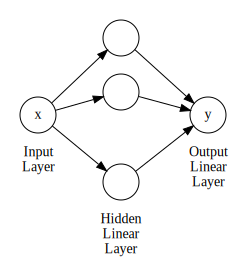

In [50]:
network_one_in_out_graph()

To support multiple inputs we need to change `a` to a `inputs x neurons` matrix and add a weighted sum like we did for our output layer.

To support multiple outputs we need to change `w` to a `neurons x outputs` matrix and `c` to a vector with `outputs` elements.

Now our hidden and output layers look the same... because they are 🙂 so let's rename the parameters for consistency.

In [51]:
def network_multi_in_out(x):
    y = x                                       # input layer
    y = (w1 * x).sum(dim=1, keepdim=True) + b1  # linear layer
    y = relu(y)                                 # activation
    y = (w2 * y).sum(dim=1, keepdim=True) + b2  # output layer
    return y

In [52]:
import graphviz

def network_multi_in_out_graph(hidden_layers=1):
    graph = graphviz.Digraph(comment="network")
    
    graph.attr(rankdir="LR", splines="line")
    graph.attr("node", label="", fixedsize="true", shape="circle", style="solid")
    
    def layer_cluster(name, prefix, label):
        with graph.subgraph(name=f"cluster_{name}") as layer:
            layer.attr(label=label, labelloc="b", color="transparent")
            
            layer.node(f"{prefix}1")
            layer.node(f"{prefix}2")
            layer.node(f"{prefix}ellipsis", label="⋮", height="0.25", color="transparent")
            layer.node(f"{prefix}n")
            
    def layer_edges(from_prefix, to_prefix):
        for from_suffix in ["1", "2", "n"]:
            for to_suffix in ["1", "2", "n"]:
                from_node = from_prefix + from_suffix
                to_node = to_prefix + to_suffix
                graph.edge(from_node, to_node)

    layer_cluster(name="input", prefix="x", label="Input\nLayer")
    
    for i in range(1, hidden_layers + 1):
        layer_cluster(name=f"hidden{i}", prefix=f"h{i}", label="Hidden\nLinear\nLayer")
    
    layer_cluster(name="output", prefix="y", label="Output\nLinear\nLayer")
    
    layer_edges(from_prefix="x",  to_prefix="h1")
    
    for i in range(1, hidden_layers):
        layer_edges(from_prefix=f"h{i}", to_prefix=f"h{i+1}")
    
    layer_edges(from_prefix=f"h{hidden_layers}", to_prefix="y")
    
    return graph

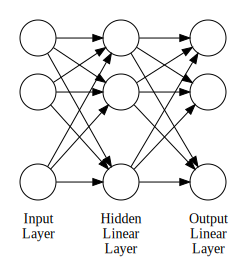

In [53]:
network_multi_in_out_graph()

We can also add more hidden layers... and so we enter deep learning

In [54]:
def network_deep(x):
    y = x                                       # input layer
    y = (w1 * x).sum(dim=1, keepdim=True) + b1  # linear layer
    y = relu(y)                                 # activation
    y = (w2 * y).sum(dim=1, keepdim=True) + b2  # linear layer
    y = relu(y)                                 # activation
    y = (w3 * y).sum(dim=1, keepdim=True) + b3  # output layer
    return y

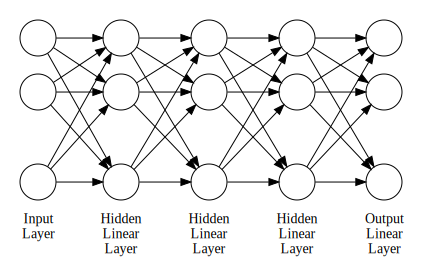

In [55]:
network_multi_in_out_graph(hidden_layers=3)

## Time for questions

Is everyone asleep?

So now you know what neural networks are and how they work.

Ideas for future talks:

- Convolutional neural networks for image-based models
- Natural language processing, e.g. sentiment analysis
- ...
- Maybe how stable diffusion and/or GPT works?

I'm open for ideas, so just ping me on Slack 😉

Links

- https://course.fast.ai/ - most of my knowledge is based on their course and book
- https://docs.fast.ai/ - `fastai` documentation
- https://github.com/mskrajnowski/2023-machine-learning-talk

## Thanks for listening

See you next time!